In [53]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [2]:
n_ids = 20000
ids_filename = '../out/ids_20k'
dt_base = '/mnt/projects/discotube/discotube-2020-09/'

metadata_file = '/scratch/palonso/data/discotube/metadata/discogs_20200901_releases.json.clean.youtube'
log01 = os.path.join(dt_base, 'discogs_20200901_releases.json.clean.youtube.ids.random.01.log')

In [3]:
metadata = pd.read_json(metadata_file, lines=True).set_index(0)

In [4]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5095522 entries, MpmbntGDyNE to B8nSNrCDBjM
Data columns (total 1 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   1       object
dtypes: object(1)
memory usage: 77.8+ MB


In [5]:
metadata.head()

,1
0,
MpmbntGDyNE,"{'1': {'genres': ['Electronic'], 'styles': ['E..."
Cawyll0pOI4,"{'1': {'genres': ['Electronic'], 'styles': ['E..."
XExCZfMCXdo,"{'1': {'genres': ['Electronic'], 'styles': ['E..."
WDZqiENap_U,"{'1': {'genres': ['Electronic'], 'styles': ['E..."
EBBHR3EMN50,"{'1': {'genres': ['Electronic'], 'styles': ['E..."


In [46]:
metadata.sample()[1][0]

{'1612869': {'genres': ['Hip Hop'],
  'styles': [],
  'released': 1998,
  'country': 'France',
  'artists': ['194'],
  'labels': ['Reel Up']},
 '1650060': {'genres': ['Hip Hop'],
  'styles': [],
  'released': 1998,
  'country': 'France',
  'artists': ['194'],
  'labels': ['Reel Up']},
 '4814182': {'genres': ['Hip Hop'],
  'styles': [],
  'released': 1998,
  'country': 'France',
  'artists': ['194'],
  'labels': ['Reel Up']},
 '13511860': {'genres': ['Hip Hop'],
  'styles': [],
  'released': 1998,
  'country': 'France',
  'artists': ['194'],
  'labels': ['Reel Up']}}

Get 20K tracks among the processed ones for prototyping

In [23]:
# !cat {log01} |grep 'downloaded\|file\ exists' | head -n {n_ids} | cut -f 1 > {ids_filename}
!find /scratch/palonso/data/discotube-specs/ -type f | head -n 5 | cut -d '/' -f 7

grep: write error
cat: write error: Broken pipe


In [7]:
with open (ids_filename, 'r') as f:
    ids = [l.rstrip() for l in f.readlines()]

In [8]:
def get_tags(entry):
    tags = set()
    for v in entry.values():
        tags.update(v['genres'])
        for s in v['styles']:
            tags.update(s.split('---'))

    return tags 

print(get_tags(metadata.sample()[1][0]))

{'Jazz', 'Swing'}


In [9]:
tag_dict = {id: get_tags(metadata.loc[id][1]) for id in ids}

In [10]:
import itertools

unique_tags = list(itertools.chain.from_iterable([list(v) for v in tag_dict.values()]))

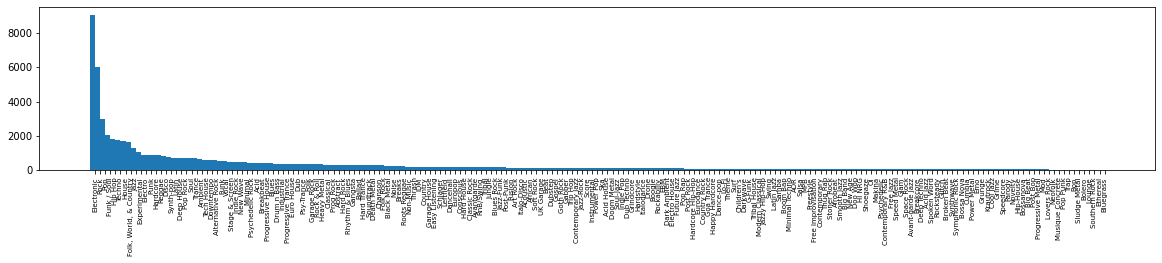

In [11]:
from collections import Counter

n_tags = 200

counts = Counter(unique_tags)
labels, values = zip(*(counts.most_common(n=n_tags)))

indexes = np.arange(len(labels))
width = 1
plt.figure(figsize=[20, 3])
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels, rotation='vertical', size=7)
plt.show()

In [12]:
print(list(zip(labels[-10:], values[-10:])))

[('Musique Concrète', 39), ('Pop Punk', 38), ('Trap', 38), ('Bop', 38), ('Sludge Metal', 38), ('Bolero', 38), ('Lounge', 37), ('Southern Rock', 37), ('Ethereal', 37), ('Bluegrass', 36)]


Below the top 200 tags, the tags have very few examples

Filter it

In [13]:
labels_t200 = set(labels)
filtered_tag_dict = dict()

for k, v in tag_dict.items():
    new_v = v.intersection(labels_t200)
    if new_v:
        filtered_tag_dict[k] = new_v

In [14]:
len(filtered_tag_dict)

19998

Only 2 files lost

In [15]:
unique_tags = []
for v in filtered_tag_dict.values():
    unique_tags += list(v)
    
print(len(set(unique_tags)))

200


In [16]:
# Enconde tags
lb = preprocessing.MultiLabelBinarizer()
lb.fit([list(labels_t200)])

lb.classes_

array(['AOR', 'Abstract', 'Acid', 'Acid House', 'Acid Jazz', 'Acoustic',
       'African', 'Afrobeat', 'Alternative Rock', 'Ambient', 'Art Rock',
       'Avant-garde Jazz', 'Avantgarde', 'Ballad', 'Beat', 'Big Band',
       'Big Beat', 'Black Metal', 'Bluegrass', 'Blues', 'Blues Rock',
       'Bolero', 'Boogie', 'Boom Bap', 'Bop', 'Bossa Nova', 'Bossanova',
       'Breakbeat', 'Breakcore', 'Breaks', 'Broken Beat', 'Chanson',
       "Children's", 'Classic Rock', 'Classical', 'Conscious',
       'Contemporary', 'Contemporary Jazz', 'Contemporary R&B',
       'Cool Jazz', 'Country', 'Country Rock', 'Cumbia', 'Dance-pop',
       'Dancehall', 'Dark Ambient', 'Darkwave', 'Death Metal',
       'Deep House', 'Deep Techno', 'Disco', 'Doo Wop', 'Doom Metal',
       'Downtempo', 'Drone', 'Drum n Bass', 'Dub', 'Dub Techno',
       'Dubstep', 'EBM', 'Easy Listening', 'Electro', 'Electro House',
       'Electronic', 'Emo', 'Ethereal', 'Euro House', 'Eurodance',
       'Europop', 'Experimental', 'Fol

In [17]:
lb.transform([['AOR'], ['AOR', 'Rock']])

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 

In [18]:
import joblib

joblib.dump(lb, '../out/encoder_20k.joblib')

['../out/encoder_20k.joblib']

In [19]:
def gt_key(key):
    return '{}/{}.mp4.mmap'.format(key[:2], key)

In [21]:
def get_artists(entry):
    artists = set()
    for v in entry.values():
        artists.update(v['artists'])
    return artists 

print(get_artists(metadata.sample()[1][0]))

{'1296859'}


In [49]:
artist_map = dict()
single_artist_tracks = []
for id in ids:
    artists = list(get_artists(metadata.loc[id][1]))
    
    if len(artists) == 1:
        single_artist_tracks.append(id)
    for artist in artists:
        artist_map[artist] = artist_map.get(artist, []) + [id]
        
single_artist_tracks = set(single_artist_tracks)

In [48]:
print(len(single_artist_tracks))

17202


In [60]:
val_tracks = []
for k, v in artist_map.items():
    if len(v) == 1:
        if v[0] in single_artist_tracks:
            val_tracks.append(v[0])

In [61]:
print(len(val_tracks))

13879


In [62]:
val_size = 3000

random.shuffle(val_tracks)
val_tracks = val_tracks[:val_size]

val_tracks = set(val_tracks)

In [63]:
mlb_labels_train = {gt_key(k): lb.transform([list(v)])[0].astype('bool') for k, v in filtered_tag_dict.items() if k not in val_tracks}
mlb_labels_val = {gt_key(k): lb.transform([list(v)])[0].astype('bool') for k, v in filtered_tag_dict.items() if k in val_tracks}

In [68]:
print('training on {} tracks, validating on {} tracks'.format(len(mlb_labels_train), len(mlb_labels_val)))

training on 16998 tracks, validating on 3000 tracks


In [69]:
import pickle

pickle_file = '../out/gt_train_20k.pk'
pickle.dump(mlb_labels_train, open(pickle_file ,'wb'))

pickle_file = '../out/gt_val_20k.pk'
pickle.dump(mlb_labels_val, open(pickle_file ,'wb'))

In [70]:
!ls -lh ../out/

total 12M
-rw-rw-r-- 1 palonso palonso 7,2K pay 10 17:40 encoder_20k.joblib
-rw-rw-r-- 1 palonso palonso 5,5M pay 10 11:19 gt_20k.pk
-rw-rw-r-- 1 palonso palonso 4,7M pay 10 18:08 gt_train_20k.pk
-rw-rw-r-- 1 palonso palonso 841K pay 10 18:08 gt_val_20k.pk
-rw-rw-r-- 1 palonso palonso 235K pay 10 09:38 ids_20k
